In [1]:
# Github trends analysis starter
import requests
import html
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Github search API
# https://docs.github.com/en/rest/reference/search#search-repositories
github_url = 'https://api.github.com/search/repositories'

In [3]:
# construct search query
q = 'marketing created:2020-01-01..2021-06-01'

# MODIFY the query: add keywords of your interest, for example
#q = '"business analytics" created:2020-01-01..2021-06-01'

In [4]:
# request parameters
qparams = {'q' : q, 'sort' : 'stars', 'order': 'desc', 'per_page' : 100}

In [5]:
# review class session on working with APIs
r = requests.get(url=github_url, params=qparams)
r

<Response [200]>

In [6]:
res = r.json()
res.keys()

dict_keys(['total_count', 'incomplete_results', 'items'])

In [7]:
# items returned in the response (first page)
len(res['items'])

100

In [8]:
# inspects results item structure
res['items'][2]

{'id': 269325451,
 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjkzMjU0NTE=',
 'name': 'sendportal',
 'full_name': 'mettle/sendportal',
 'private': False,
 'owner': {'login': 'mettle',
  'id': 1176340,
  'node_id': 'MDEyOk9yZ2FuaXphdGlvbjExNzYzNDA=',
  'avatar_url': 'https://avatars.githubusercontent.com/u/1176340?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/mettle',
  'html_url': 'https://github.com/mettle',
  'followers_url': 'https://api.github.com/users/mettle/followers',
  'following_url': 'https://api.github.com/users/mettle/following{/other_user}',
  'gists_url': 'https://api.github.com/users/mettle/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/mettle/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/mettle/subscriptions',
  'organizations_url': 'https://api.github.com/users/mettle/orgs',
  'repos_url': 'https://api.github.com/users/mettle/repos',
  'events_url': 'https://api.github.com/users/mettle/events{/privacy}',
  're

In [9]:
res['items'][2]['description']

'Open-source self-hosted email marketing. Manage your own newsletters at a fraction of the cost. '

In [10]:
# total number of top repositories collected
len(res['items'])

100

In [11]:
stop_words = set(stopwords.words('english'))

# text cleaning function
def text_cleanup(s):
    # if not a string object, disregard
    if not isinstance(s, str):
        return ''
    
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and w.isalnum()]
    
    # return clean string
    return ' '.join(wt_filt)

In [12]:
# clean text of repository descriotions
text_cleanup(res['items'][2]['description'])

'email marketing manage newsletters fraction cost'

In [13]:
# list of cleaned-up top repository description strings
descr = [text_cleanup(r['description']) for r in res['items']]

In [14]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in descr])

In [15]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [16]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('email', 'marketing'), 3),
 (('open', 'source'), 4),
 (('digital', 'marketing'), 4),
 (('marketing', 'mix'), 4),
 (('mix', 'modeling'), 3),
 (('machine', 'learning'), 3),
 (('marketing', 'site'), 4),
 (('customer', 'segmentation'), 6),
 (('marketing', 'website'), 7),
 (('hms', 'dtm'), 4),
 (('dtm', 'demo'), 4),
 (('demo', 'provides'), 4),
 (('provides', 'guidance'), 4),
 (('guidance', 'developers'), 4),
 (('developers', 'use'), 4),
 (('use', 'hms'), 4),
 (('hms', 'dynamic'), 4),
 (('dynamic', 'tag'), 4),
 (('tag', 'manager'), 4),
 (('manager', 'illustrates'), 4),
 (('illustrates', 'track'), 4),
 (('track', 'specific'), 4),
 (('specific', 'events'), 4),
 (('events', 'report'), 4),
 (('report', 'data'), 4),
 (('data', 'analytics'), 4),
 (('analytics', 'platforms'), 4),
 (('platforms', 'monitoring'), 4),
 (('monitoring', 'marketing'), 4),
 (('marketing', 'activity'), 4),
 (('activity', 'data'), 4),
 (('data', 'needed'), 4)]

In [17]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
marketing website,7
customer segmentation,6
data analytics,4
manager illustrates,4
illustrates track,4
track specific,4
specific events,4
events report,4
report data,4


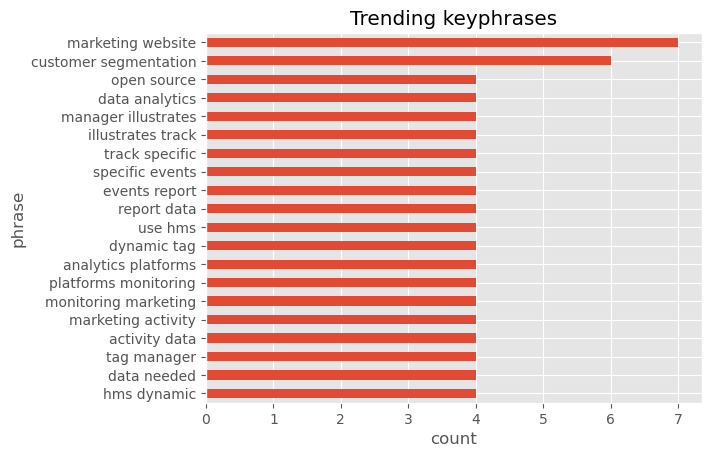

In [18]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()